# Goal

* Mapping alpha diversity onto phylogeny

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylo_map/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host cladogram distance
host_tree_SpecD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_SpecD.nwk'

# alpha-div calculated with qiime2
alpha_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/alpha_div.RDS'

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
library(phytools)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘stringr’ was built under R version 3.4.3”Loading required package: ape
Loading required package: maps


# Load

## phyloseq

In [3]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30368 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30368 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30368 tips and 29832 internal nodes ]

In [4]:
metadata = physeq %>% 
    sample_data %>% 
    as.matrix %>% 
    as.data.frame %>%
    mutate(SampleID = rownames(.))

metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 214 172


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,SampleID
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,X1.Eurasian.Beaver
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,X101.Horse
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,X102.Kulan


## Host phylogeny

In [5]:
host_tree = read.tree(host_tree_SpecD_file)
host_tree


Phylogenetic tree with 129 tips and 128 internal nodes.

Tip labels:
	Sander_lucioperca, Esox_lucius, Salvelinus_fontinalis, Aspius_aspius, Leuciscus_idus, Blicca_bjoerkna, ...
Node labels:
	, @_22_@, @_8_@, @_7_@, @_20_@, @_17_@, ...

Rooted; includes branch lengths.

In [6]:
setdiff(metadata$scientific_name, host_tree$tip.label) %>% print
setdiff(host_tree$tip.label, metadata$scientific_name) %>% print

character(0)
character(0)


## Alpha div

In [7]:
# load alpha-div values
alpha_div = readRDS(alpha_div_file)
alpha_div = do.call(cbind, alpha_div)
alpha_div$X.SampleID = rownames(alpha_div) 

alpha_div = alpha_div %>%
    gather(index, index_value, -X.SampleID)

alpha_div %>% status

[1] 856   3


X.SampleID,index,index_value
X1.Eurasian.Beaver,pielou_e,0.6507254
X101.Horse,pielou_e,0.9042161
X102.Kulan,pielou_e,0.8443325


# Aggregating alpha-div by species

In [8]:
# adding scientific_name
alpha_div_j = alpha_div %>%
    inner_join(metadata %>% dplyr::select(X.SampleID, class, order, 
                                          family, genus, 
                                          scientific_name, diet),
               c('X.SampleID')) 
alpha_div_j %>% status

Warning message:
“Column `X.SampleID` joining character vector and factor, coercing into character vector”

[1] 856   9


X.SampleID,index,index_value,class,order,family,genus,scientific_name,diet
X1.Eurasian.Beaver,pielou_e,0.6507254,Mammalia,Rodentia,Castoridae,Castor,Castor_fiber,herbivore
X101.Horse,pielou_e,0.9042161,Mammalia,Perissodactyla,Equidae,Equus,Equus_caballus,herbivore
X102.Kulan,pielou_e,0.8443325,Mammalia,Perissodactyla,Equidae,Equus,Equus_hemionus,herbivore


In [9]:
# number of samples per species 
alpha_div_j %>%
    distinct(X.SampleID, scientific_name) %>%
    group_by(scientific_name) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.659   2.000  11.000 

# Format for itol

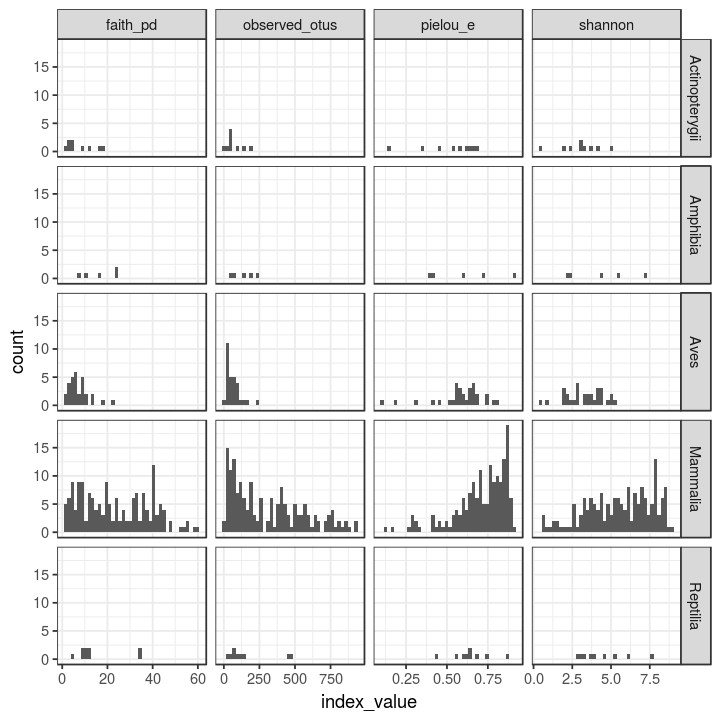

In [10]:
# distribution by alpha-div metric & host-class
p = ggplot(alpha_div_j, aes(index_value)) +
    geom_histogram(bins=40) +
    facet_grid(class ~ index, scales='free_x') +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=6)
plot(p)

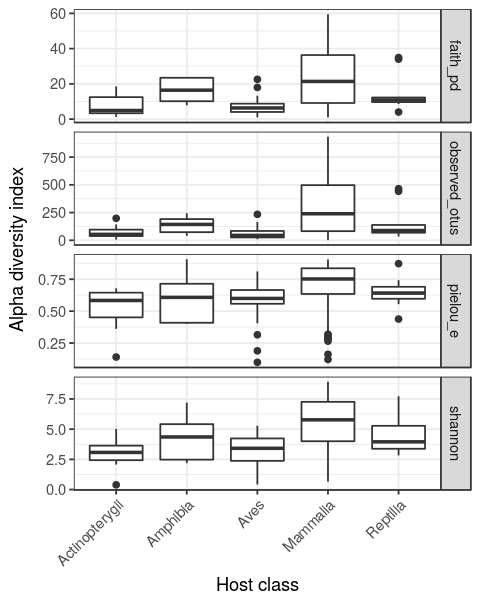

In [11]:
# distribution by alpha-div metric & host-class
p = ggplot(alpha_div_j, aes(class, index_value)) +
    geom_boxplot() +
    labs(x='Host class', y='Alpha diversity index') +
    facet_grid(index ~ ., scales='free_y') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=4, repr.plot.height=5)
plot(p)

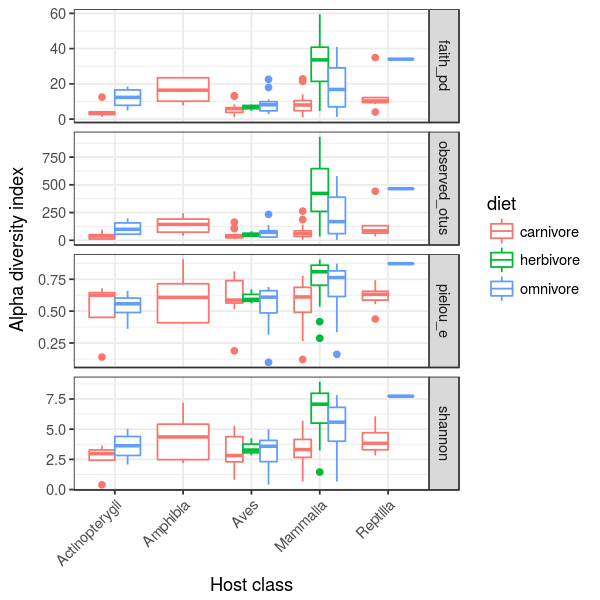

In [12]:
# distribution by alpha-div metric & host-class
p = ggplot(alpha_div_j, aes(class, index_value, color=diet)) +
    geom_boxplot() +
    labs(x='Host class', y='Alpha diversity index') +
    facet_grid(index ~ ., scales='free_y') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=5)
plot(p)

## Mammalia & Aves

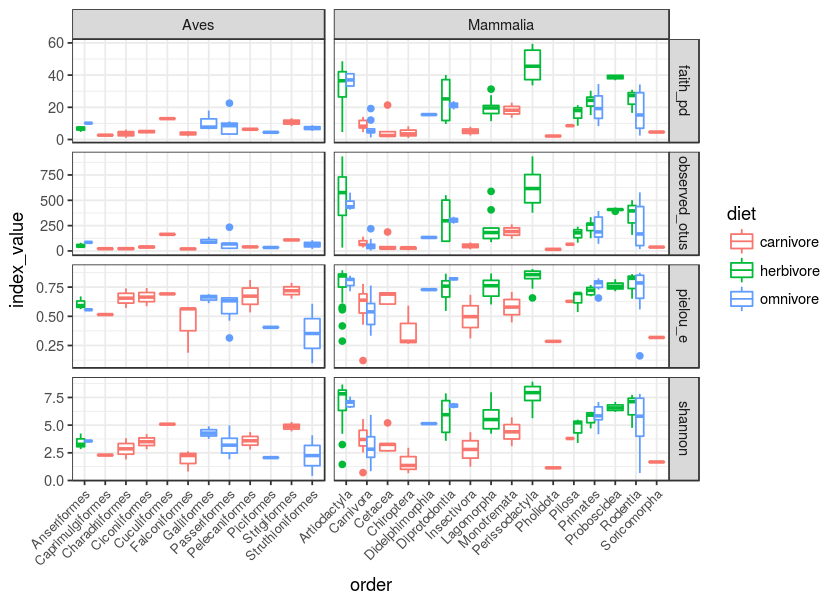

In [13]:
# distribution by alpha-div metric & host-class
tmp = alpha_div_j %>% 
    filter(class %in% c('Mammalia', 'Aves')) %>%
    mutate(order = order %>% reorder(class %>% as.factor %>% as.numeric))
    
p = ggplot(tmp, aes(order, index_value, color=diet)) +
    geom_boxplot() +
    facet_grid(index ~ class, scales='free', space='free_x') +
    theme_bw() +
    theme(
        axis.text.x = element_text(size=8, angle=45, hjust=1)
    )

options(repr.plot.width=7, repr.plot.height=5)
plot(p)

## itol format

In [14]:
# formatting
m = alpha_div_j %>%
    group_by(scientific_name, index) %>%
    summarize(minimum = min(index_value),
              q1 = quantile(index_value, 0.25),
              median = median(index_value),
              q3 = quantile(index_value, 0.75),
              maximum = max(index_value)) %>%
    ungroup()

m %>% status

[1] 516   7


scientific_name,index,minimum,q1,median,q3,maximum
Acrocephalus_scirpaceus,faith_pd,9.0860150,9.0860150,9.0860150,9.0860150,9.0860150
Acrocephalus_scirpaceus,observed_otus,73.0000000,73.0000000,73.0000000,73.0000000,73.0000000
Acrocephalus_scirpaceus,pielou_e,0.5827143,0.5827143,0.5827143,0.5827143,0.5827143


In [15]:
# spliting by metric & writing each to file
write_itol_file = function(df, metric, out_file, work_dir){
    itol_box_file = file.path(work_dir, out_file)
    
    cat('DATASET_BOXPLOT\n', file=itol_box_file)
    cat('SEPARATOR SPACE\n', file=itol_box_file, append=TRUE)
    cat(sprintf('DATASET_LABEL %s\n', metric), file=itol_box_file, append=TRUE)
    cat('COLOR #ff0000\n', file=itol_box_file, append=TRUE)
    cat('DATA\n', file=itol_box_file, append=TRUE)
    write.table(df, file=itol_box_file, append=TRUE, sep=' ', 
                quote=FALSE, row.names=FALSE, col.names=FALSE)
    cat('File written:', itol_box_file, '\n')
}

for(x in unique(m$index)){
    m_f = m[m$index==x,]
    m_f$index = NULL
    out_file = paste0(x, '_iTOL-boxplot.txt')
    write_itol_file(m_f, x, out_file, work_dir)
}

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylo_map//faith_pd_iTOL-boxplot.txt 
File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylo_map//observed_otus_iTOL-boxplot.txt 
File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylo_map//pielou_e_iTOL-boxplot.txt 
File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylo_map//shannon_iTOL-boxplot.txt 


# contMap plots

### Faith's PD

In [25]:
alpha_div_j_s = alpha_div_j %>%
    filter(index == 'faith_pd') %>%
    group_by(scientific_name) %>%
    summarize(mean_value = mean(index_value)) %>%
    ungroup()

trait = alpha_div_j_s$mean_value
names(trait) = alpha_div_j_s$scientific_name
trait %>% length %>% print
trait %>% summary

[1] 129


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.008   5.920  12.223  16.346  23.890  49.757 

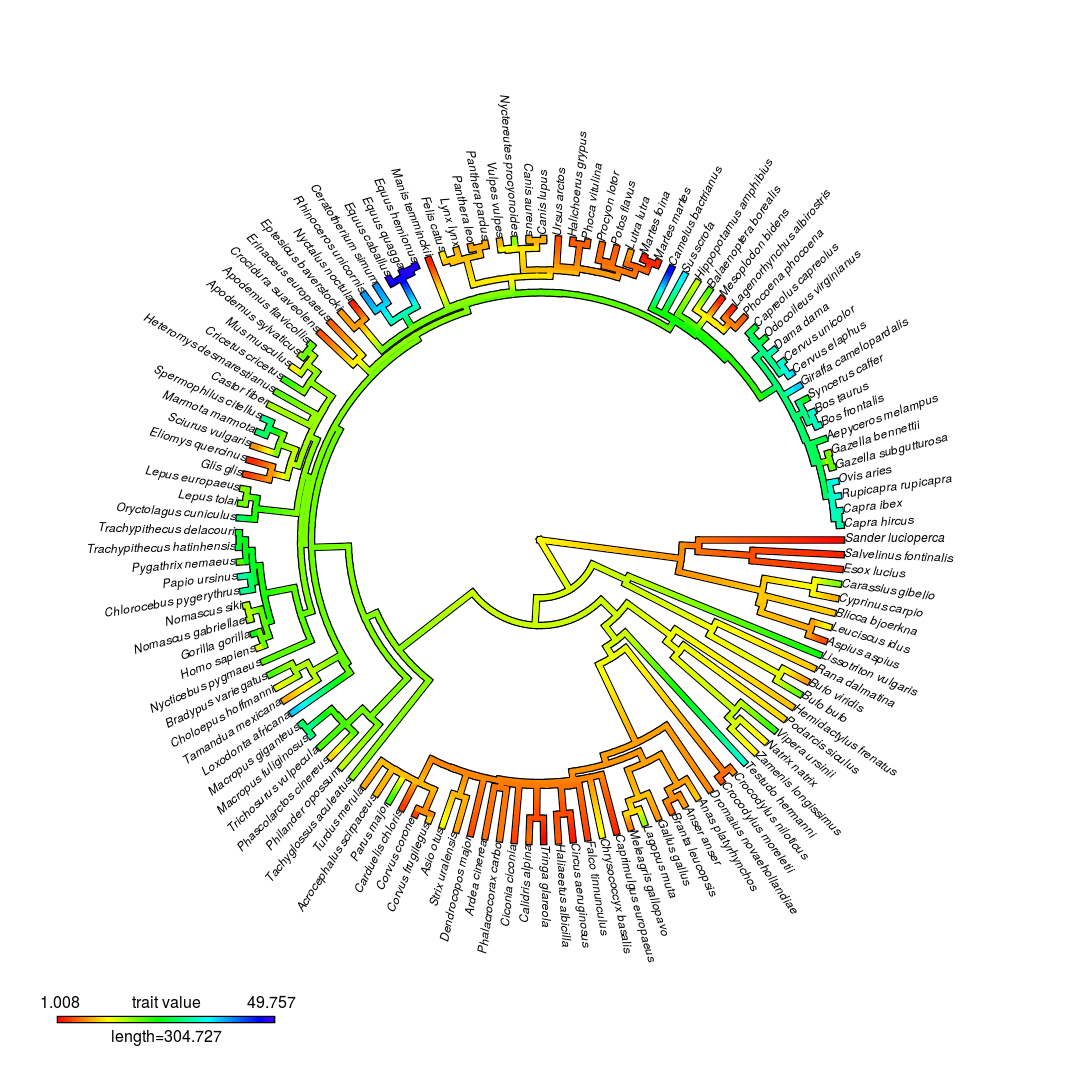

In [27]:
options(repr.plot.width=9, repr.plot.height=9)
obj_faithPD = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_faithPD, type="fan", legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

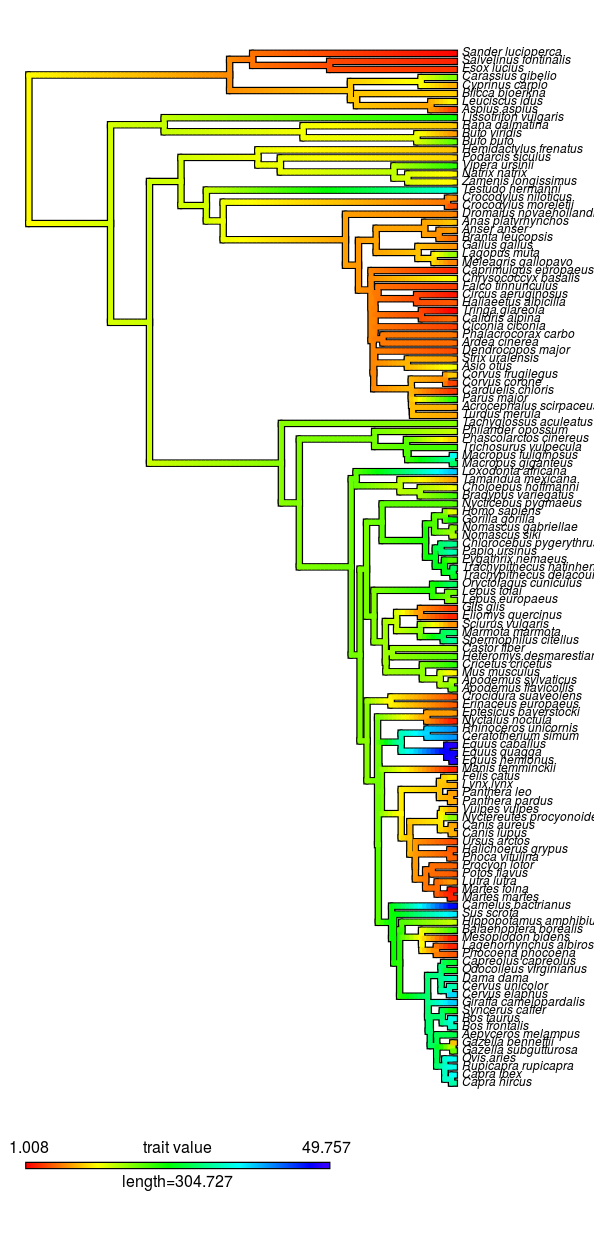

In [28]:
options(repr.plot.width=5, repr.plot.height=10.5)
obj_faithPD = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_faithPD, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

### Shannon

In [29]:
alpha_div_j_s = alpha_div_j %>%
    filter(index == 'shannon') %>%
    group_by(scientific_name) %>%
    summarize(mean_value = mean(index_value)) %>%
    ungroup()

trait = alpha_div_j_s$mean_value
names(trait) = alpha_div_j_s$scientific_name
trait %>% length %>% print
trait %>% summary

[1] 129


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3933  3.0027  4.3987  4.5222  5.9293  8.2023 

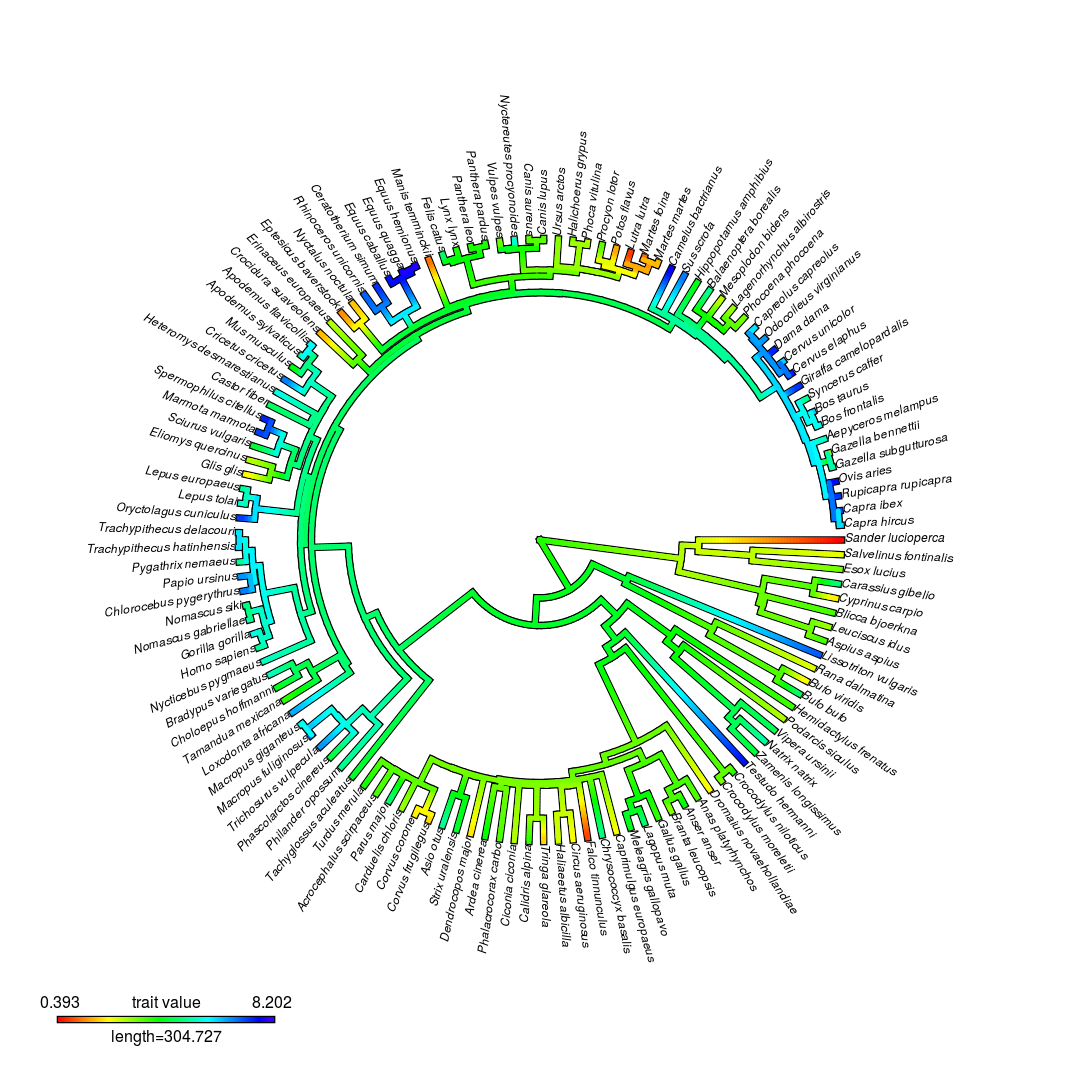

In [30]:
options(repr.plot.width=9, repr.plot.height=9)
obj_shannon = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_shannon, type="fan", legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

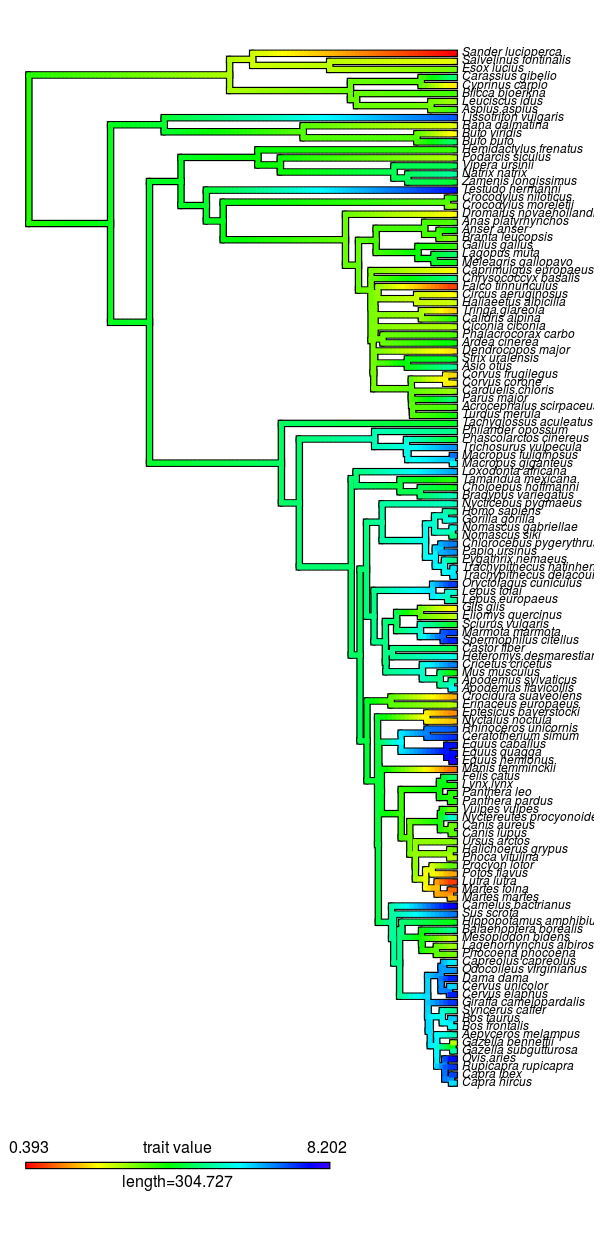

In [31]:
options(repr.plot.width=5, repr.plot.height=10.5)
obj_shannon = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_shannon, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

### diet

In [32]:
alpha_div_j_s = alpha_div_j %>%
    filter(index == 'shannon') %>%
    group_by(scientific_name) %>%
    summarize(diet = first(diet)) %>%
    ungroup() %>%
    mutate(diet = ifelse(diet == 'carnivore', 0, ifelse(diet == 'herbivore', 1, 0.5) ))

trait = alpha_div_j_s$diet
names(trait) = alpha_div_j_s$scientific_name
trait %>% length %>% print
trait %>% summary

[1] 129


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.5000  0.4729  1.0000  1.0000 

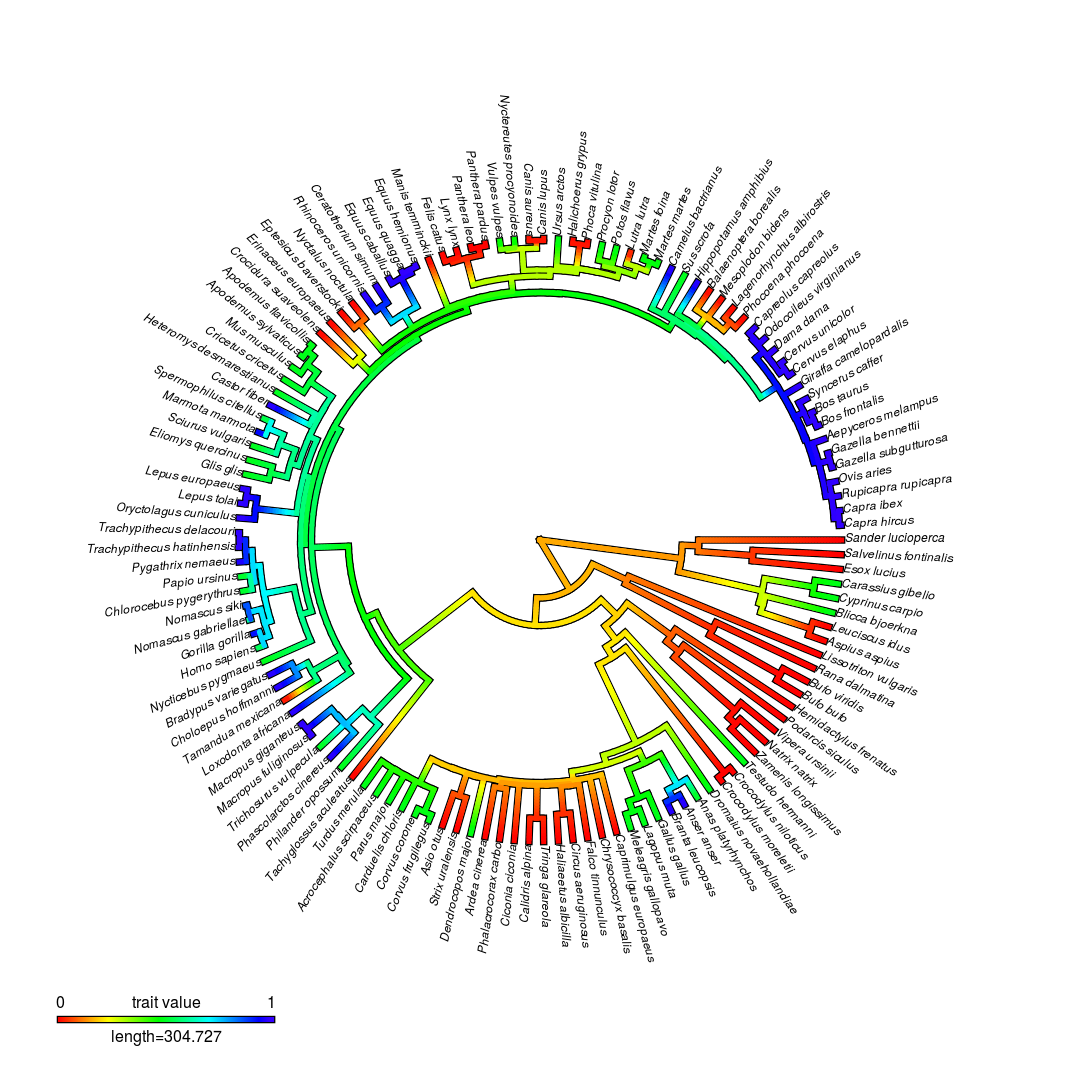

In [33]:
options(repr.plot.width=9, repr.plot.height=9)
obj_diet = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_diet, type="fan", legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

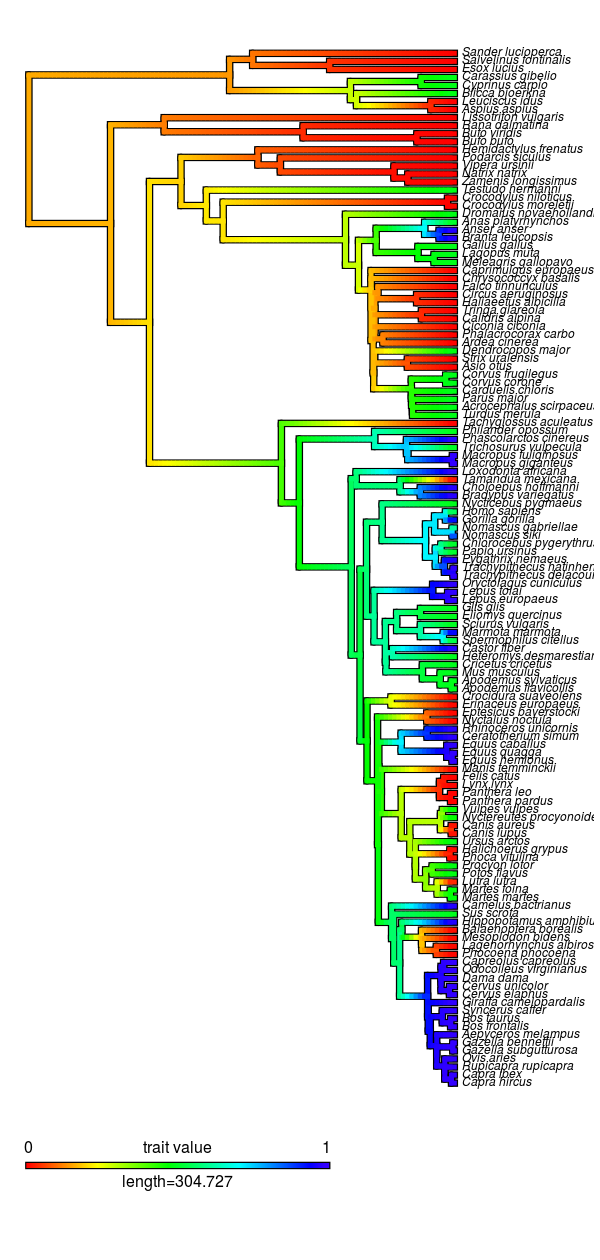

In [34]:
options(repr.plot.width=5, repr.plot.height=10.5)
obj_diet = contMap(ladderize(host_tree), trait, plot=FALSE)
plot(obj_diet, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8))

### Comparing diet to diversity

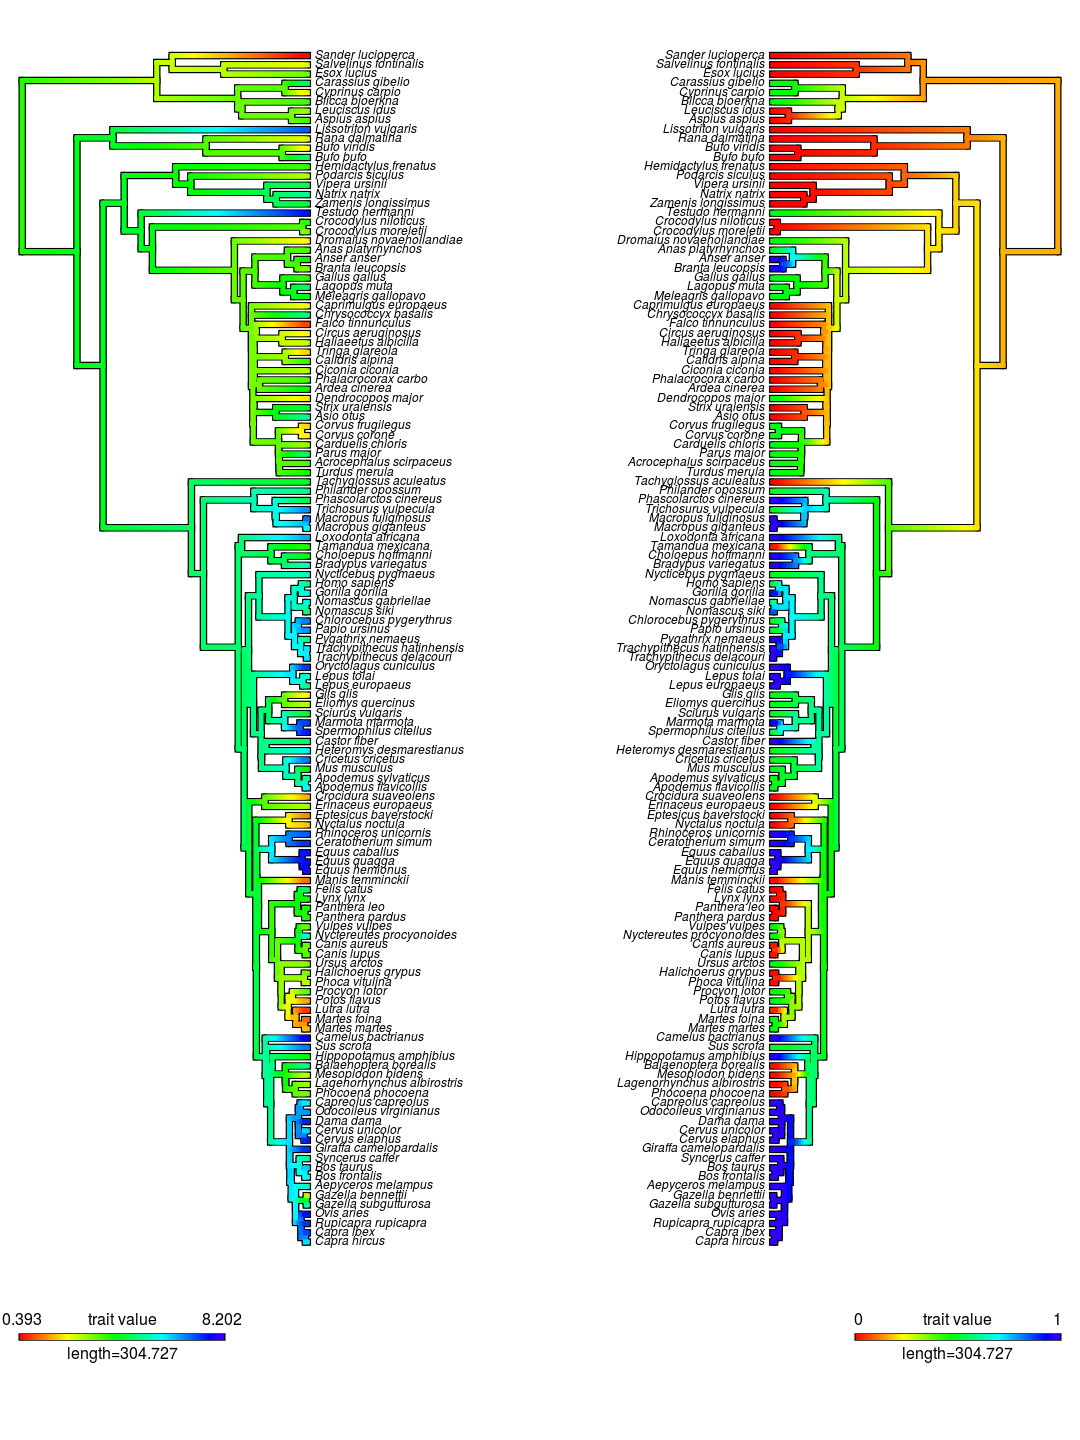

In [40]:
# comparing diet 
par(mfrow=c(1,2))
options(repr.plot.width=9, repr.plot.height=12)
plot(obj_shannon, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8), mar=c(rep(0.1, 4)))
plot(obj_diet, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8), mar=c(rep(0.1, 4)), direction='leftwards')

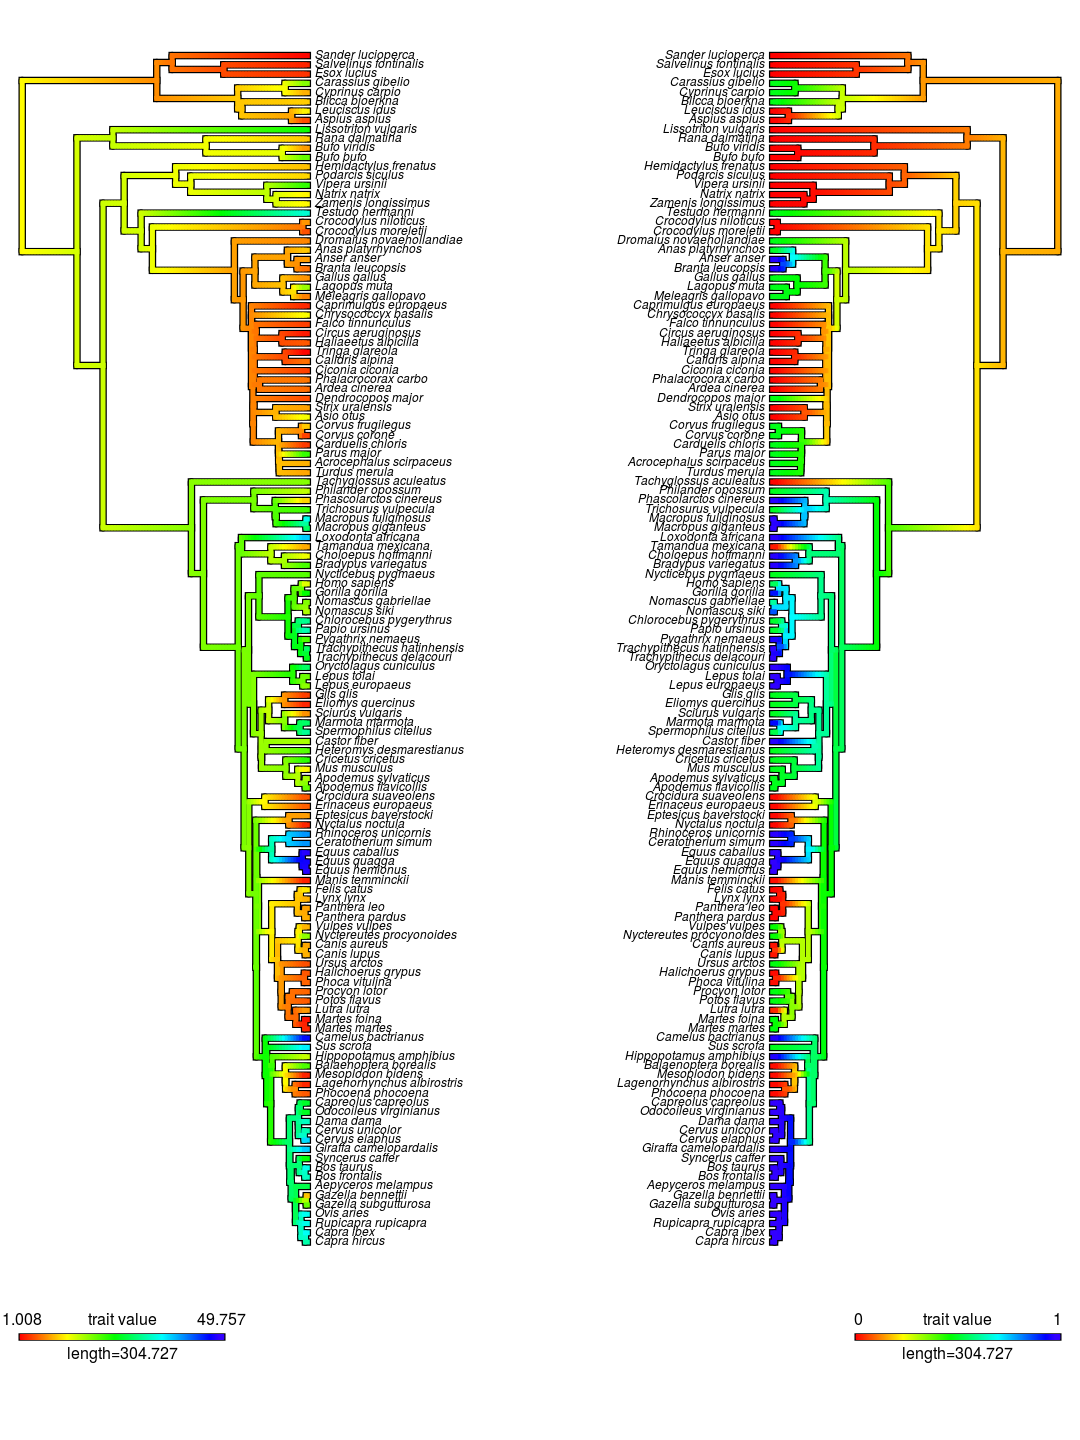

In [39]:
# comparing diet 
par(mfrow=c(1,2))
options(repr.plot.width=9, repr.plot.height=12)
plot(obj_faithPD, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8), mar=c(rep(0.1, 4)))
plot(obj_diet, legend=0.7*max(nodeHeights(host_tree)), fsize=c(0.6,0.8), mar=c(rep(0.1, 4)), direction='leftwards')

# sessionInfo()

In [38]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2    phytools_0.6-44 maps_3.3.0      ape_5.1        
[5] phyloseq_1.22.3 stringr_1.2.0   ggplot2_2.2.1   tidyr_0.8.1    
[9] dplyr_0.7.4    

loaded via a namespace (and not attached):
